# Training ResNet34 based Encoder-Decoder

In [1]:
import time
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.insert(0, dir1)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from ummon import *
import torchvision.models as models


from models.resnet34_encoder_decoder import ResNet, FCN8s
from utils.water_segmentation import Water
from utils import metrics, dataset_statistics

from matplotlib import pyplot as plt
import numpy as np

In [2]:
from utils.segmentation_analyzer import SegmentationAnalyzer
from utils.segmentation_trainer import SegmentationTrainer, SegmentationLogger
import json

def train(data_loader_trn, data_load_val, opt, model, epochs, path, additional_logger):
    
   
    
    loss = nn.BCEWithLogitsLoss()

    # training state
    trs = Trainingstate()

    #Additional logger
    seg_logger = additional_logger

    # optimizer
    #opt = optim.Adam(model.parameters(),lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=False)
    loss = nn.BCEWithLogitsLoss()

    with Logger(loglevel=10, logdir='.', log_batch_interval=20) as lg:
    
        # trainer
        trn = SegmentationTrainer(lg, model, loss, opt, trainingstate=trs, model_filename=path, 
                              combined_training_epochs=0, additional_logger=seg_logger)
    
        # train
        trn.fit(data_loader_trn, epochs=epochs, validation_set=data_loader_val, analyzer=SegmentationAnalyzer)
    
    
        ## evaluate on test set
        trs.load_weights_best_validation_(model)
        ev = SegmentationAnalyzer.evaluate(model, loss, data_loader_val, lg)
        lg.info("Performance on validation set: \nloss={:6.4f} \niou={:.4f} \nacc={:.4f} \nsensitivity={:.4f} \nspecificity={:.4f} \nprecision={:.4f} \nf1={:.4f}".format(
            ev["loss"], ev["iou"],ev["accuracy"], ev["sensitivity"], ev["specificity"], ev["precision"], ev["f1"]))

In [3]:
import matplotlib.pyplot as plt
def visualize_training(data):
    plt.rcParams["figure.figsize"] = (8,5)
    plt.rcParams['axes.xmargin'] = 0
    plt.plot(data["epoch_trn"], data["loss_trn"], label="training loss")
    plt.plot(data["epoch_trn"], data["loss_val"], label="validation loss")
    plt.xlabel('Epochen')
    plt.ylabel('BCE loss')
    plt.legend(loc='best')   
    plt.show()
    print("Minimum validation loss: {0:f} at epoch {1}".format(min(data["loss_val"]), data["loss_val"].index(min(data["loss_val"]))+1))
    print("Minimum training loss: {0:f} at epoch {1}".format(min(data["loss_trn"]), data["loss_trn"].index(min(data["loss_trn"]))+1))
    
    print("Maximum validation IoU: {0:f} at epoch {1}".format(max(data["iou_val"]), data["iou_val"].index(max(data["iou_val"]))+1))
    print("Maximum training IoU: {0:f} at epoch {1}".format(max(data["iou_trn"]), data["iou_trn"].index(max(data["iou_trn"]))+1))

# Training on "Tampere" Dataset only
### Configuration

In [4]:
batch_size = 4
identifier = 'ResNet34_Enc_Dec_Tamp_RMS_lr_e-4'
directory = "../data/training_states/ResNet34_Enc_Dec"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-4
weight_decay = 1e-5
momentum = 0

# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet34 = models.resnet34(pretrained=True)
res_model = ResNet(resnet34)
model = FCN8s(res_model, 1).to(device)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])


### Dataset ###

In [5]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.TAMP_OPEN_DOCK

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=['open','dock'], data_list_misc=[],
                    data_constance = False, transforms=norm, img_size=(960,640))
dataset_val = Water('../data/WaterDataset', data_list_tamp=['channel'], data_list_misc=[],
                    data_constance = False, transforms=norm, img_size=(960,640))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

400 images in training dataset
200 images in validation dataset


### Training ###

In [6]:
train(data_loader, data_loader_val, optimizer, model, epochs, path, additional_logger = logger)
logger.save_results(path + "_learning_log.json")

[System]
Host                dennis-ios
Platform            Linux-4.15.0-204-generic-x86_64-with-glibc2.17
CUDA                10.2
CuDNN               7605
Python              ['3.8.13 (default, Mar 28 2022, 11:38:47) ', '[GCC 7.5.0]']
Numpy               1.21.5
Torch               1.11.0
Torchvision         0.12.0
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
FCN8s(
  (pretrained_net): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

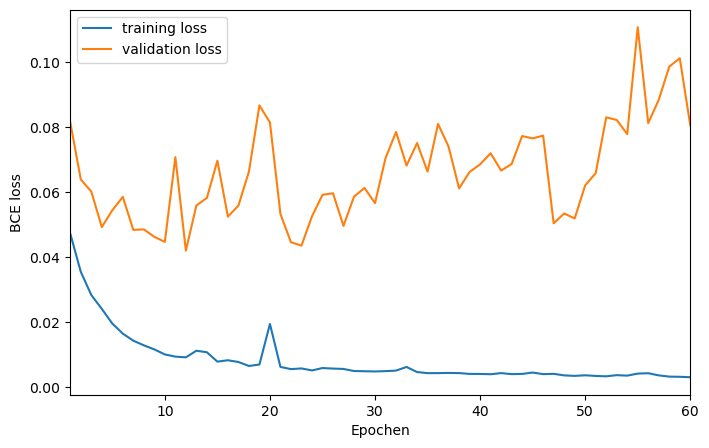

Minimum validation loss: 0.041987 at epoch 12
Minimum training loss: 0.003033 at epoch 60
Maximum validation IoU: 0.974600 at epoch 22
Maximum training IoU: 0.997140 at epoch 60


In [7]:
data = json.load(open(directory +"/ResNet34_Enc_Dec_Tamp_RMS_lr_e-4" + "_learning_log.json"))
visualize_training(data)

# Training on "Misc" Dataset only
### Configuration

In [8]:
batch_size = 4
identifier = 'ResNet34_Enc_Dec_Misc_RMS_lr_e-4'
directory = "../data/training_states/ResNet34_Enc_Dec"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-4
weight_decay = 1e-5
momentum = 0

In [9]:
# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet34 = models.resnet34(pretrained=True)
res_model = ResNet(resnet34)
model = FCN8s(res_model, 1).to(device)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])

### Dataset ###

In [10]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.MISC_TRAINING

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=[], data_list_misc=['training'],
                    data_constance = False, transforms=norm, img_size=(960,640))
dataset_val = Water('../data/WaterDataset', data_list_tamp=[], data_list_misc=['validation'],
                    data_constance = False, transforms=norm, img_size=(960,640))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

2188 images in training dataset
212 images in validation dataset


### Training ###

In [11]:
train(data_loader, data_loader_val, optimizer, model, epochs, path, logger)
logger.save_results(path + "_learning_log.json")

[System]
Host                dennis-ios
Platform            Linux-4.15.0-204-generic-x86_64-with-glibc2.17
CUDA                10.2
CuDNN               7605
Python              ['3.8.13 (default, Mar 28 2022, 11:38:47) ', '[GCC 7.5.0]']
Numpy               1.21.5
Torch               1.11.0
Torchvision         0.12.0
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
FCN8s(
  (pretrained_net): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

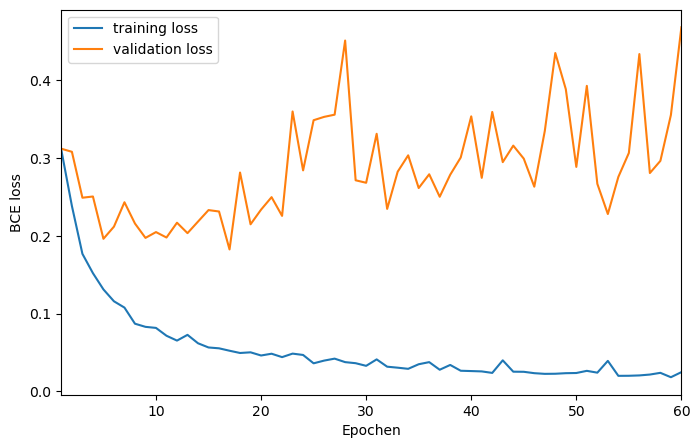

Minimum validation loss: 0.182494 at epoch 17
Minimum training loss: 0.018289 at epoch 59
Maximum validation IoU: 0.799272 at epoch 17
Maximum training IoU: 0.966539 at epoch 59


In [12]:
data = json.load(open(directory +"/ResNet34_Enc_Dec_Misc_RMS_lr_e-4" + "_learning_log.json"))
visualize_training(data)

# Training on "Tampere" and "Misc" Dataset
### Configuration

In [13]:
batch_size = 4
identifier = 'ResNet34_Enc_Dec_Combined_RMS_lr_e-4_nopretrain'
directory = "../data/training_states/ResNet34_Enc_Dec"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-4
weight_decay = 1e-5
momentum = 0

In [14]:
# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet34 = models.resnet34(pretrained=True)
res_model = ResNet(resnet34)
model = FCN8s(res_model, 1).to(device)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])

### Dataset ###

In [15]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.TAMP_OPEN_DOCK_MISC_TRN

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=["open", "dock"], data_list_misc=['training'],
                    data_constance = False, transforms=norm, img_size=(960,640))
dataset_val = Water('../data/WaterDataset', data_list_tamp=["channel"], data_list_misc=['validation'],
                    data_constance = False, transforms=norm, img_size=(960,640))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

2588 images in training dataset
412 images in validation dataset


### Training ###

In [16]:
train(data_loader, data_loader_val, optimizer, model, epochs, path, logger)
logger.save_results(path + "_learning_log.json")

[System]
Host                dennis-ios
Platform            Linux-4.15.0-204-generic-x86_64-with-glibc2.17
CUDA                10.2
CuDNN               7605
Python              ['3.8.13 (default, Mar 28 2022, 11:38:47) ', '[GCC 7.5.0]']
Numpy               1.21.5
Torch               1.11.0
Torchvision         0.12.0
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
FCN8s(
  (pretrained_net): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

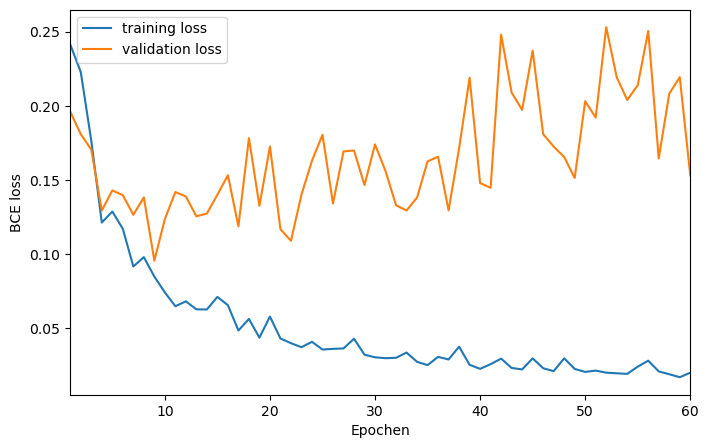

Minimum validation loss: 0.095489 at epoch 9
Minimum training loss: 0.016843 at epoch 59
Maximum validation IoU: 0.890310 at epoch 22
Maximum training IoU: 0.971577 at epoch 59


In [18]:
data = json.load(open(directory +"/ResNet34_Enc_Dec_Combined_RMS_lr_e-4_nopretrain" + "_learning_log.json"))
visualize_training(data)